In [1]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from pycaret.regression import *
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [2]:
# reading data from csv
df = pd.read_csv('Data\mudah-apartment-kl-selangor.csv')

# dropping duplicates
df = df.drop_duplicates()

# displaying first 5 rows of dataset
df.head()

,ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
0,100323185,The Hipster @ Taman Desa,2022.0,RM 4 200 per month,Kuala Lumpur - Taman Desa,Condominium,5,2.0,6.0,1842 sq.ft.,Fully Furnished,"Minimart, Gymnasium, Security, Playground, Swi...","Air-Cond, Cooking Allowed, Washing Machine",Kuala Lumpur
1,100203973,Segar Courts,NaN,RM 2 300 per month,Kuala Lumpur - Cheras,Condominium,3,1.0,2.0,1170 sq.ft.,Partially Furnished,"Playground, Parking, Barbeque area, Security, ...","Air-Cond, Cooking Allowed, Near KTM/LRT",Kuala Lumpur
2,100323128,Pangsapuri Teratak Muhibbah 2,NaN,RM 1 000 per month,Kuala Lumpur - Taman Desa,Apartment,3,NaN,2.0,650 sq.ft.,Fully Furnished,"Minimart, Jogging Track, Lift, Swimming Pool",NaN,Kuala Lumpur
3,100191767,Sentul Point Suite Apartment,2020.0,RM 1 700 per month,Kuala Lumpur - Sentul,Apartment,2,1.0,2.0,743 sq.ft.,Partially Furnished,"Parking, Playground, Swimming Pool, Squash Cou...","Cooking Allowed, Near KTM/LRT, Washing Machine",Kuala Lumpur
4,97022692,Arte Mont Kiara,NaN,RM 1 299 per month,Kuala Lumpur - Mont Kiara,Service Residence,1,1.0,1.0,494 sq.ft.,Not Furnished,"Parking, Security, Lift, Swimming Pool, Playgr...",Air-Cond,Kuala Lumpur


## Exploratory Data Analysis

### Data Types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19983 entries, 0 to 19990
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ads_id                 19983 non-null  int64  
 1   prop_name              19035 non-null  object 
 2   completion_year        10802 non-null  float64
 3   monthly_rent           19981 non-null  object 
 4   location               19983 non-null  object 
 5   property_type          19983 non-null  object 
 6   rooms                  19977 non-null  object 
 7   parking                14284 non-null  float64
 8   bathroom               19977 non-null  float64
 9   size                   19983 non-null  object 
 10  furnished              19978 non-null  object 
 11  facilities             17775 non-null  object 
 12  additional_facilities  14038 non-null  object 
 13  region                 19983 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 2.3+

In [4]:
df.shape

(19983, 14)

In [5]:
# ads_id - object
# completion year - object/datetime64
# monthly_rent - float64/ int64
# rooms - int64
# size - float64/ int64

In [6]:
df['completion_year'].unique()

array([2022.,   nan, 2020., 2018., 2014., 2019., 2017., 2021., 2006.,
       2015., 1999., 2004., 2007., 2002., 1985., 2010., 2012., 1988.,
       1998., 2023., 1990., 2016., 2003., 2000., 2008., 1995., 2013.,
       2011., 1994., 2009., 1996., 2005., 1993., 1997., 2001., 2025.,
       1980., 1989., 1987., 1984., 2024., 1991., 1977.])

'completion_year' can be converted to dt format

In [7]:
# converting 'completion_year' to datetime
df['completion_year'] = pd.to_datetime(df['completion_year'], format='%Y')

In [8]:
df['completion_year'].head()

0   2022-01-01
1          NaT
2          NaT
3   2020-01-01
4          NaT
Name: completion_year, dtype: datetime64[ns]

'completion_year' is in dt format now

In [9]:
df['monthly_rent'].head()

0    RM 4 200 per month
1    RM 2 300 per month
2    RM 1 000 per month
3    RM 1 700 per month
4    RM 1 299 per month
Name: monthly_rent, dtype: object

Currency unit has to be removed from the values in the 'monthly_rent' column

In [10]:
# extracting numbers from 'monthly_rent' column
df['monthly_rent'] = df['monthly_rent'].str.extractall(r'(\d+)').astype(str).groupby(level=0).agg(''.join).astype(int)

In [11]:
df['monthly_rent'].head()

0    4200.0
1    2300.0
2    1000.0
3    1700.0
4    1299.0
Name: monthly_rent, dtype: float64

Currency unit is removed from 'monthly_rent' column and converted to float

In [12]:
df['rooms'].unique()

array(['5', '3', '2', '1', '4', '7', '6', 'More than 10', nan, '9', '3.0',
       '4.0', '2.0', '1.0', '5.0', '9.0', '6.0', '7.0', '10.0'],
      dtype=object)

Need to remove category 'More than 10' from the 'rooms' column

In [13]:
# replacing 'More than 10' category with 11
df['rooms'] = df['rooms'].replace({'More than 10': 11}).astype(float)

In [14]:
df['rooms'].head()

0    5.0
1    3.0
2    3.0
3    2.0
4    1.0
Name: rooms, dtype: float64

'rooms' have been converted to float

In [15]:
df['size'].head()

0    1842 sq.ft.
1    1170 sq.ft.
2     650 sq.ft.
3     743 sq.ft.
4     494 sq.ft.
Name: size, dtype: object

Need to remove unit from the values in the 'size' column

In [16]:
# extracting numbers from 'size' column
df['size'] = df['size'].str.extractall(r'(\d+)').astype(str).groupby(level=0).agg(''.join).astype(float)

In [17]:
df['size'].head()

0    1842.0
1    1170.0
2     650.0
3     743.0
4     494.0
Name: size, dtype: float64

Unit is removed from 'size' column and converted to float

In [18]:
# renaming columns
df = df.rename(columns={'monthly_rent': 'monthly_rent_rm', 'size': 'size_sqft'})

### Numerical columns

In [19]:
# defining the numerical columns
num_cols = ['monthly_rent_rm', 'rooms', 'parking', 'bathroom', 'size_sqft']

In [20]:
# viewing summary of the numerical columns
df[num_cols].describe()

,monthly_rent_rm,rooms,parking,bathroom,size_sqft
count,1.998100e+04,19977.000000,14284.000000,19977.000000,1.998300e+04
mean,2.269295e+03,2.681133,1.416900,1.891776,5.924176e+03
std,2.241733e+04,0.812116,0.567403,0.556212,7.074011e+05
min,7.000000e+01,1.000000,1.000000,1.000000,1.000000e+00
25%,1.100000e+03,2.000000,1.000000,2.000000,7.500000e+02
50%,1.400000e+03,3.000000,1.000000,2.000000,8.860000e+02
75%,1.800000e+03,3.000000,2.000000,2.000000,1.044000e+03
max,2.400000e+06,11.000000,10.000000,8.000000,1.000000e+08


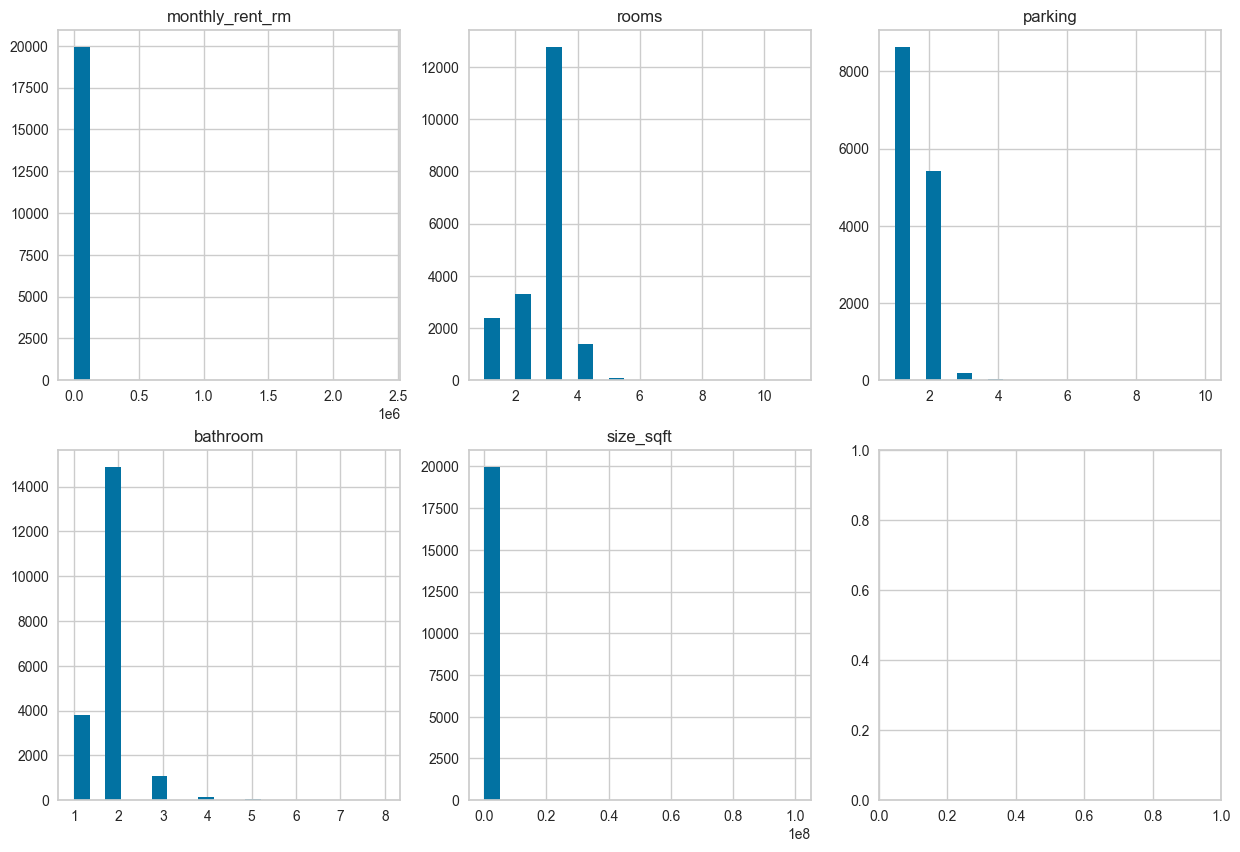

In [21]:
# Plotting the histogram of the numerical columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    ax[i].hist(df[col], bins=20)
    ax[i].set_title(col)

All the numerical variables appear to have lognormal distributions. Transformation can be applied to fix this.

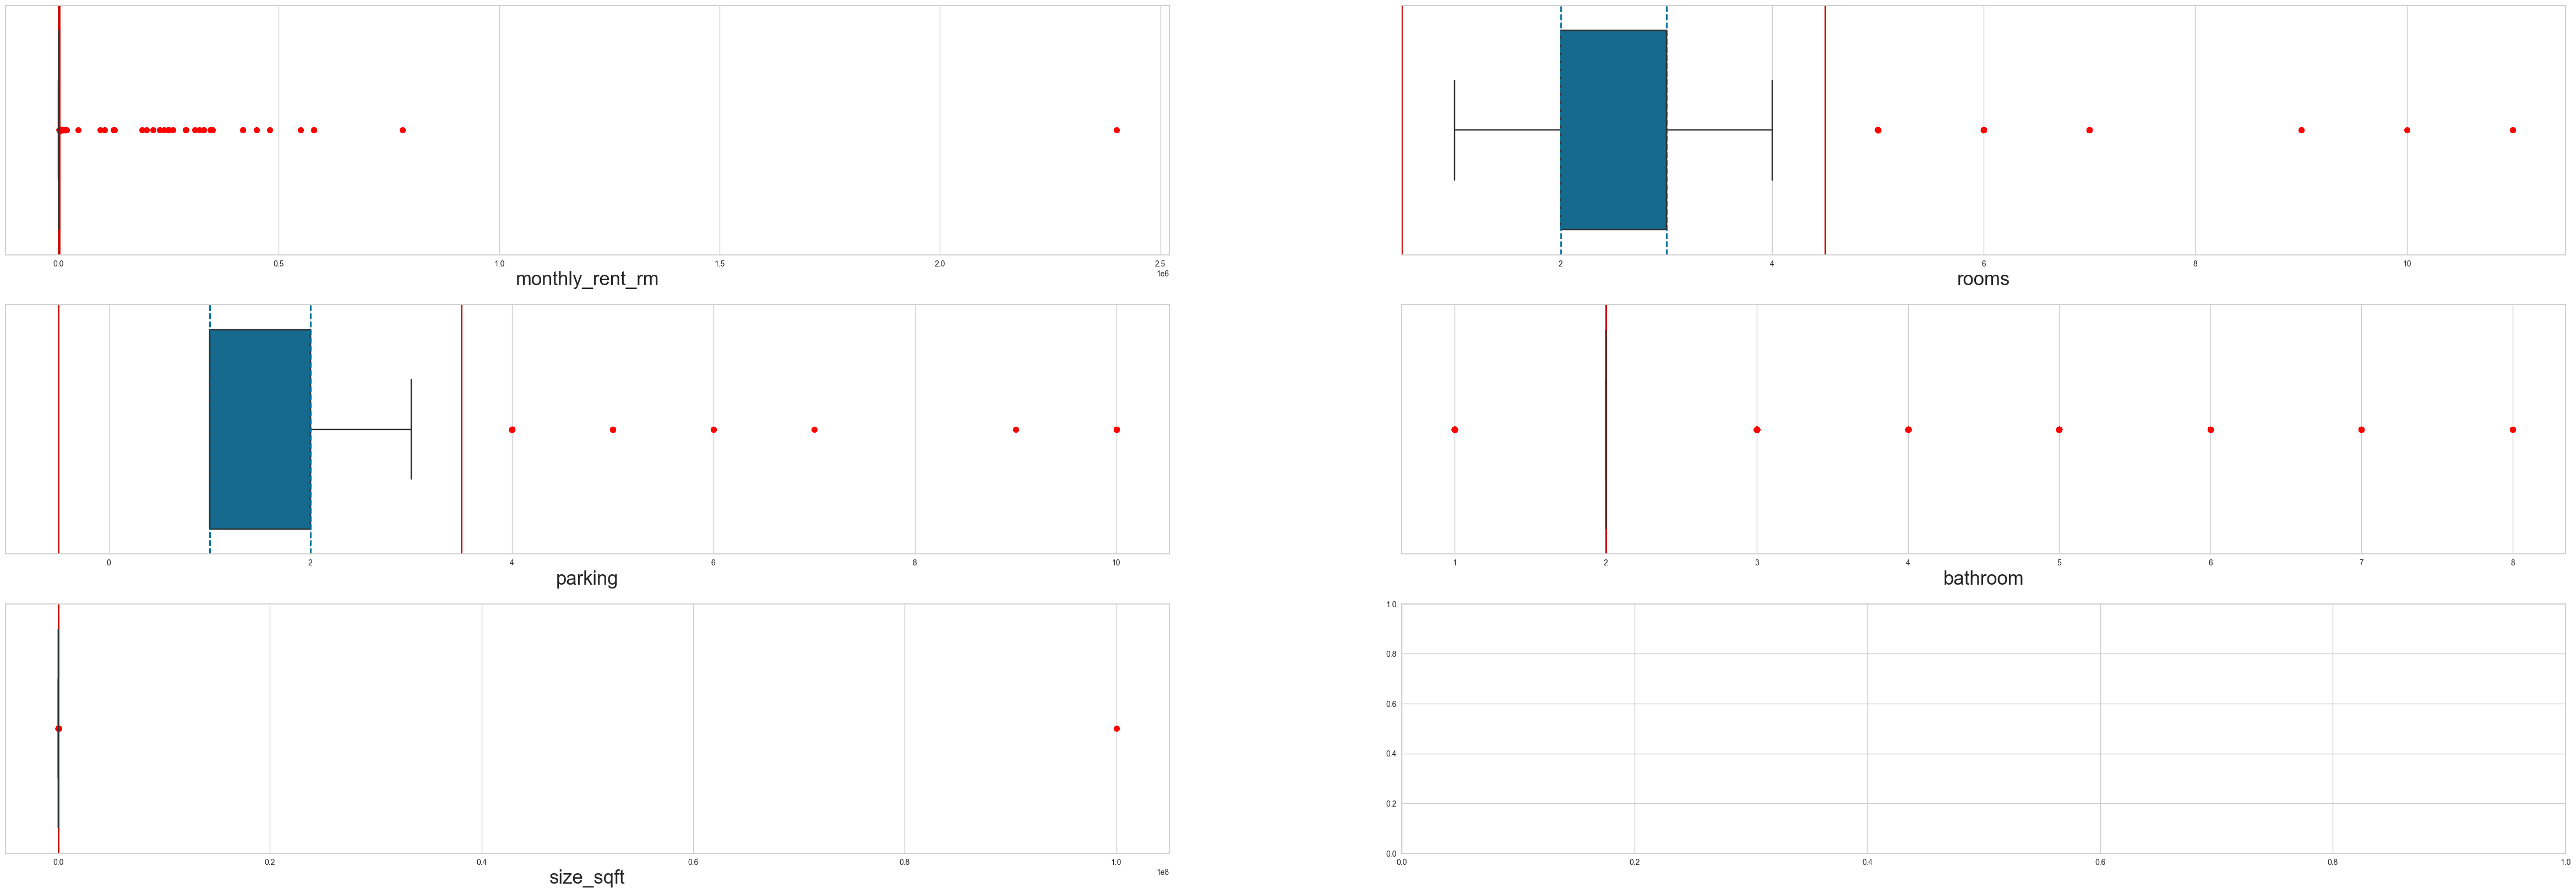

In [22]:
fig, ax = plt.subplots(nrows=math.ceil(len(num_cols)/2), ncols =2, figsize=(60, 20))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    # Plotting histogram of all numerical features
    sns.boxplot(data=df, x=col, ax=ax[i], flierprops={
        "marker": "o",
        "markeredgewidth": 1,
        "markersize": 7,
        "markerfacecolor": "red",
        "markeredgecolor": "red",
    })
    ax[i].set_xlabel(col, fontsize=25)

    q1 = df[col].quantile(0.25)
    q2 = df[col].quantile(0.50)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    ax[i].axvline(q1, linestyle='--', linewidth=2)
    ax[i].axvline(q2, linestyle='--', linewidth=2)
    ax[i].axvline(q3, linestyle='--', linewidth=2)
    ax[i].axvline(q1 - 1.5 * iqr, color = "r", linestyle='-', linewidth=2)
    ax[i].axvline(q3 + 1.5 * iqr, color = "r", linestyle='-', linewidth=2)
plt.show()

'monthly_rent_rm' and 'size_sqft' appears to have extreme outliers. These outliers can be removed.

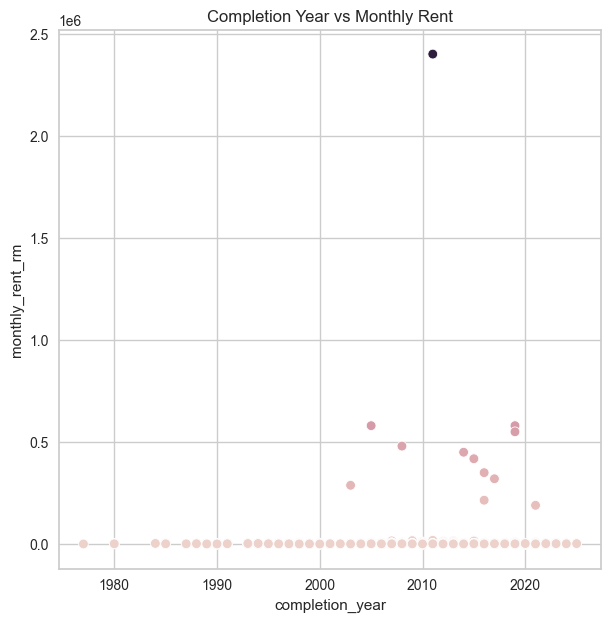

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x=df['completion_year'], y=df['monthly_rent_rm'], hue=df['monthly_rent_rm'], legend=False)
plt.title('Completion Year vs Monthly Rent')
plt.show()

Extreme outlier in 'monthly_rent_rm' column prevent the scatterplot to display the distribution of the rental price effectively.

In [24]:
def clip_outliers(df, col, percentile):

    col_upper_limit = df[col].quantile(percentile)
    col_lower_limit = df[col].quantile(1-percentile)
    df[col] = df[col].clip(upper=col_upper_limit, lower=col_lower_limit)

    return df

In [25]:
df = clip_outliers(df, 'monthly_rent_rm', 0.97)

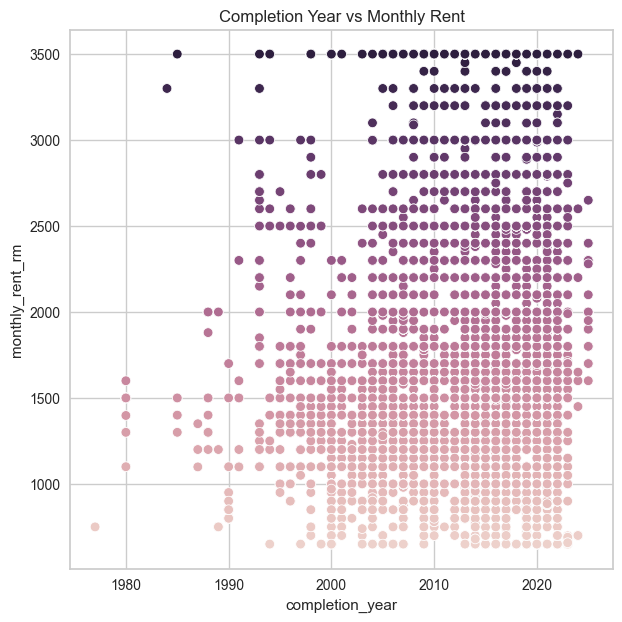

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x=df['completion_year'], y=df['monthly_rent_rm'], hue=df['monthly_rent_rm'], legend=False)
plt.title('Completion Year vs Monthly Rent')
plt.show()

### Categorical columns

In [27]:
# defining the categorical columns
cat_col = ["location", "property_type", "furnished", "region", "facilities", "additional_facilities"] # left 'completion_year', 'ads_id', and 'prop_name'

In [28]:
# viewing the summary of the categorical columns
df[cat_col].describe(include="all")

,location,property_type,furnished,region,facilities,additional_facilities
count,19983,19983,19978,19983,17775,14038
unique,134,13,3,2,10785,176
top,Kuala Lumpur - Cheras,Condominium,Fully Furnished,Selangor,"Parking, Security, Lift, Swimming Pool, Playgr...","Air-Cond, Cooking Allowed, Washing Machine"
freq,1623,8448,8457,9992,872,1927


In [29]:
for col in cat_col:
    print(f"Column: {col}")
    print(df[col].value_counts().head())
    print("")

Column: location
Kuala Lumpur - Cheras     1623
Selangor - Kajang         1022
Kuala Lumpur - Setapak     973
Selangor - Shah Alam       970
Selangor - Cyberjaya       879
Name: location, dtype: int64

Column: property_type
Condominium          8448
Service Residence    5305
Apartment            5255
Flat                  581
Studio                189
Name: property_type, dtype: int64

Column: furnished
Fully Furnished        8457
Partially Furnished    8001
Not Furnished          3520
Name: furnished, dtype: int64

Column: region
Selangor        9992
Kuala Lumpur    9991
Name: region, dtype: int64

Column: facilities
Parking, Security, Lift, Swimming Pool, Playground, Gymnasium, Sauna, Barbeque area, Minimart, Multipurpose hall, Club house, Jogging Track, Tennis Court, Squash Court    872
Parking                                                                                                                                                                    238
Parking, Security, Lift,

In [30]:
for col in cat_col:

    print(f"There are {df[col].nunique()} unique values in {col} column.")


There are 134 unique values in location column.
There are 13 unique values in property_type column.
There are 3 unique values in furnished column.
There are 2 unique values in region column.
There are 10785 unique values in facilities column.
There are 176 unique values in additional_facilities column.


"facilities" and "additional_facilities" column can be expanded to multiple binary columns where the value is dependent upon the availability of the facility. While, 'location', 'property_type', 'furnished' and 'region' can be one-hot encoded. As there are 134 unique values in the location column. We will also use principal component analysis to reduce the dimension of the location columns.

### Missing value analysis

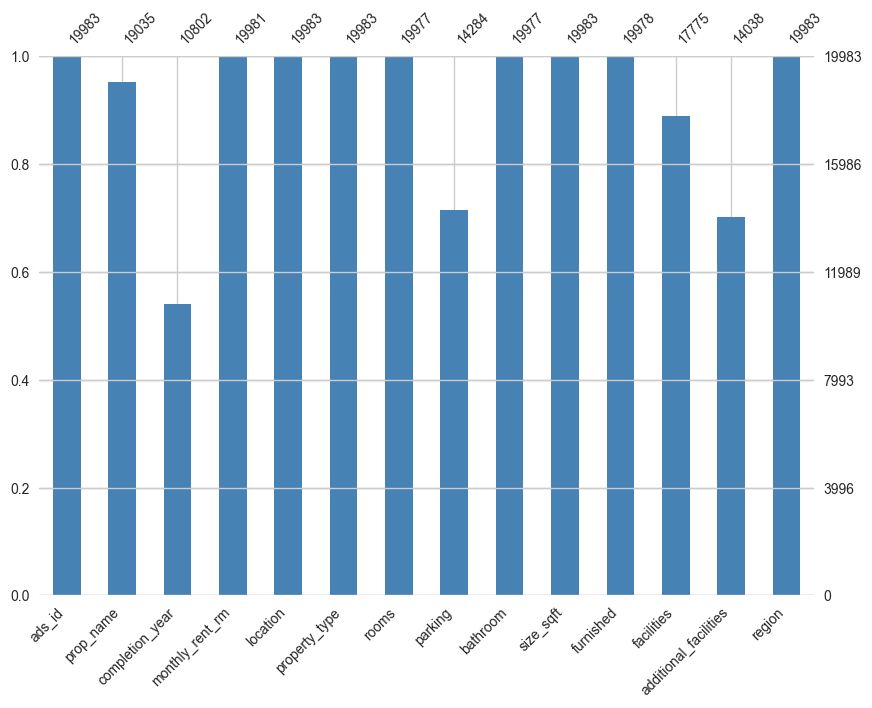

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))

msno.bar(df, ax=ax, fontsize=10, color='steelblue')
plt.show()

There's missing values in the target column, "monthly_rent_rm", which needs to be removed.

In [32]:
df = df[df['monthly_rent_rm'].isna() == False]

In [33]:
df["monthly_rent_rm"].isna().any()

False

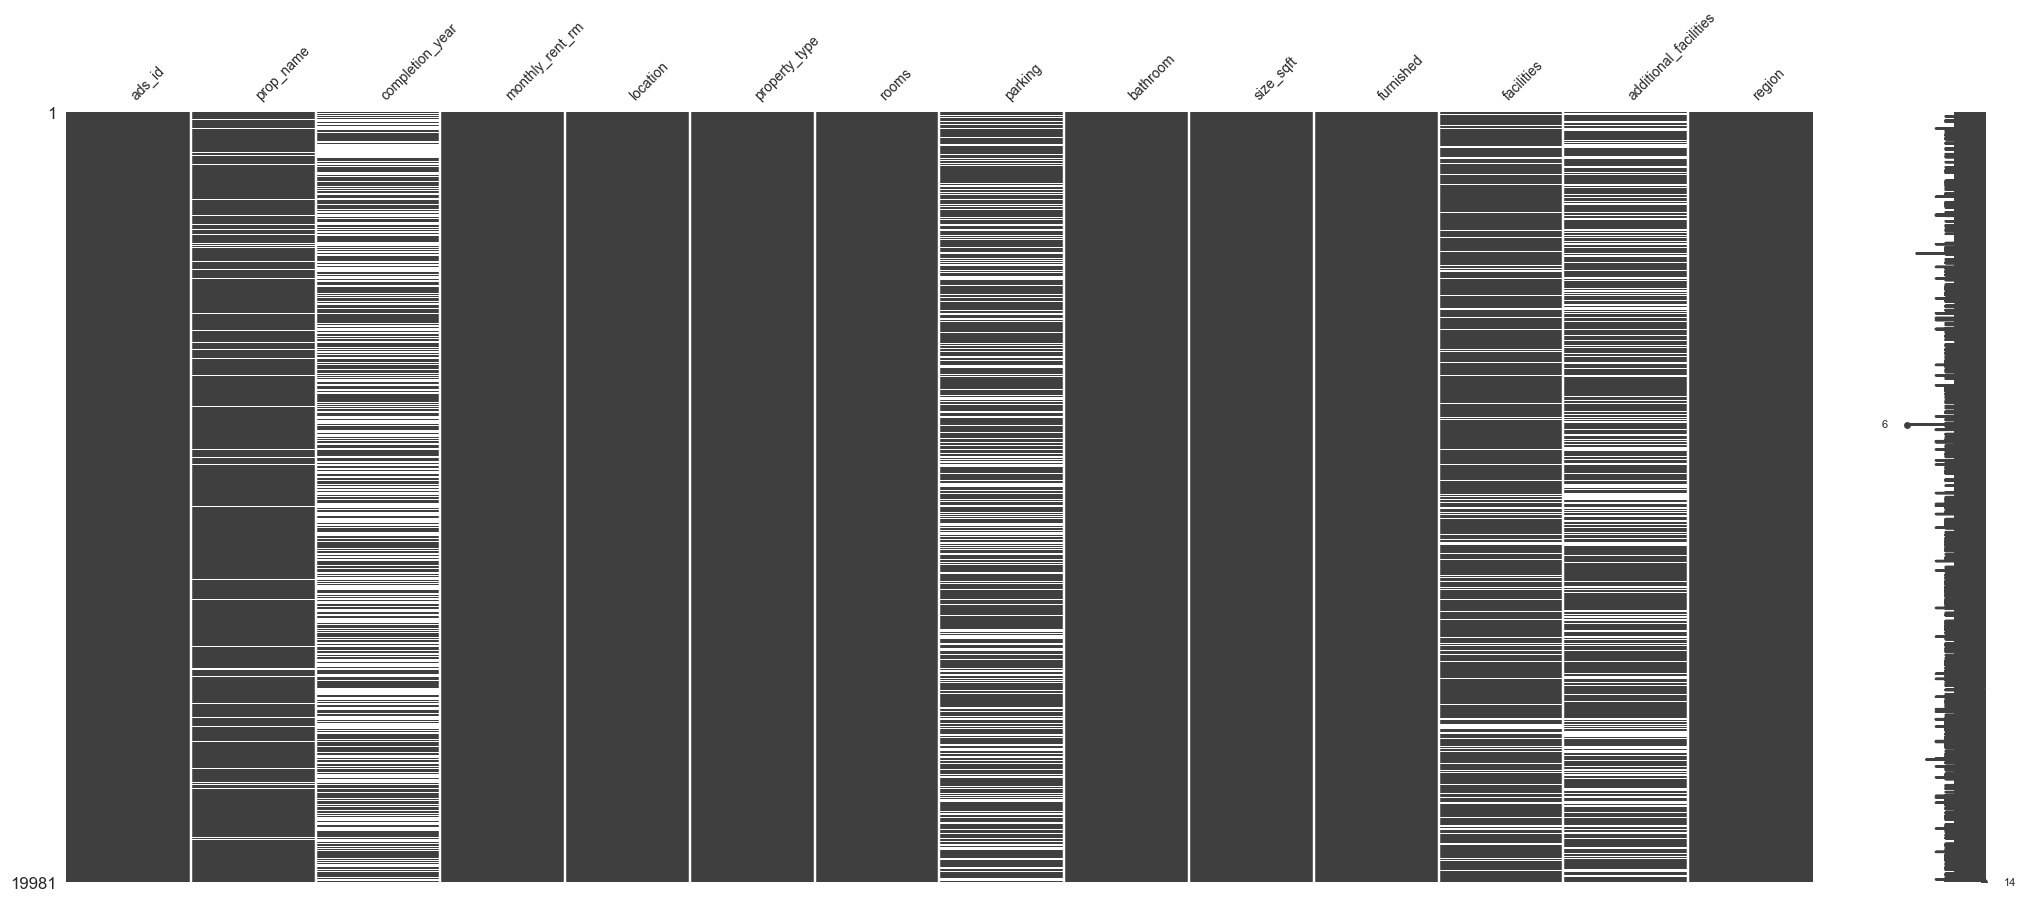

In [34]:
# fig, ax = plt.subplots(figsize=(10, 7))

msno.matrix(df, fontsize=10)
plt.show()

## PyCaret

PyCaret is an open source Python machine learning library inspired by the 'caret' package in R that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially and makes you more productive. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks such as scikit-learn, XGBoost, Microsoft LightGBM, spaCy and many more. PyCaret abstracts the implementation level complexities of various machine learning libraries from the end-user and allows the user to quickly implement and compare over 25 commonly used machine learning algorithms from a single, unified and simple interface.

PyCaret automates many steps of a machine learning project, such as:
- Defining the data preprocessing steps (e.g. missing value imputation, categorical encoding, etc.)
- Evaluating and comparing baseline models
- Tuning model hyperparameters

In [35]:
class CreateColumns(TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):

        for i in ['facilities', 'additional_facilities']:
            
            X = pd.concat([X, self.get_columns(X, i)], axis=1)
            X.drop([i], axis=1, inplace=True)
        
        return X
    
    def fit_transform(self, X, y=None):

        return self.fit(X).transform(X)
    
    # Defining a function to create dummy variables based on the values in the 'facilities' and 'additional_facilities' columns
    def create_columns(self, df, col_name):

        temp = df.copy()
        temp[col_name] = temp[col_name].apply(lambda x: re.sub(r'\d+', '', str(x)))
        temp[col_name] = temp[col_name].apply(lambda x: re.sub(r'\s+', '', str(x)))
        temp[col_name] = temp[col_name].str.split(',')

        new_cols = pd.get_dummies(temp[col_name].apply(pd.Series).stack()).groupby(level=0).sum().astype(float)

        return new_cols
    
    def get_columns(self, df, column):
        
        cols = self.create_columns(df, column)

        for col in cols.columns:
            if (col in ['', 'nan']) or (col is None):
                cols.drop([col], axis=1, inplace=True)
        
        return cols

In [36]:
from sklearn.decomposition import PCA

class LocationTransformer(TransformerMixin):

    def __init__(self, n_components):
        
        self.n_components = n_components

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):

        ohe_loc = pd.get_dummies(X['location'], prefix='loc')

        pca = PCA(n_components=self.n_components)

        transformed_loc = pd.DataFrame(pca.fit_transform(ohe_loc)).add_prefix('loc_')

        X.reset_index(drop=True, inplace=True)

        X = pd.concat([X, transformed_loc], axis=1)
        
        X.drop(['location'], axis=1, inplace=True)

        return X

    def fit_transform(self, X, y=None):

        return self.fit(X).transform(X)

In [37]:
# pipeline = Pipeline(steps=[('Create_columns', CreateColumns()), ('PCA', LocationTransformer(n_components=14)),])

In [38]:
pipeline_2 = Pipeline(steps=[('Create_columns', CreateColumns()),])

In [39]:
reg = setup(data=df,
            target='monthly_rent_rm',
            numeric_features=['rooms', 'parking', 'bathroom', 'size_sqft'],
            categorical_features=['location', 'property_type', 'furnished', 'region', 'facilities', 'additional_facilities'],
            ignore_features=['ads_id', 'prop_name', 'completion_year'],
            # preprocess=False,
            imputation_type='simple',
            categorical_imputation='mode',
            numeric_imputation='median',
            # iterative_imputation_iters=10,
            normalize=True,
            remove_outliers=True,
            outliers_method='iforest',
            outliers_threshold=0.05,
            custom_pipeline=pipeline_2, 
            custom_pipeline_position=2, 
            session_id=10,
            )

# https://pycaret.readthedocs.io/en/latest/api/regression.html#pycaret.regression.setup

,Description,Value
0,Session id,10
1,Target,monthly_rent_rm
2,Target type,Regression
3,Original data shape,"(19981, 14)"
4,Transformed data shape,"(19281, 40)"
5,Transformed train set shape,"(13286, 40)"
6,Transformed test set shape,"(5995, 40)"
7,Ignore features,3
8,Ordinal features,1
9,Numeric features,4


In [40]:
get_config('pipeline')

Pipeline(memory=FastMemory(location=C:\Users\MOY~1.TIA\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['rooms', 'parking', 'bathroom',
                                             'size_sqft'],
                                    transformer=SimpleImputer(strategy='median'))),
                ('categorical_imputer',
                 TransformerWrapper(include=['location', 'property_type',
                                             'furnished', 'region',
                                             'facilities',
                                             'additional...
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('rest_encoding',
                 TransformerWrapper(include=['location', 'facilities',
                                             'additional_facilities'],
                                    transformer=TargetEncoder(cols=['location'],
                                                              handle_missing='return_nan'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=10))),
                ('normalize',
                 TransformerWrapper(transformer=StandardScaler()))])

In [41]:
X_train = get_config('X_train')
X_train_transformed = get_config('X_train_transformed')

X_test = get_config('X_test')
X_test_transformed = get_config('X_test_transformed')

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13986 entries, 1673 to 17682
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   location               13986 non-null  category
 1   property_type          13986 non-null  category
 2   rooms                  13983 non-null  float32 
 3   parking                9984 non-null   float32 
 4   bathroom               13983 non-null  float32 
 5   size_sqft              13986 non-null  float32 
 6   furnished              13984 non-null  category
 7   facilities             12429 non-null  category
 8   additional_facilities  9809 non-null   category
 9   region                 13986 non-null  category
dtypes: category(6), float32(4)
memory usage: 804.2 KB


In [43]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13286 entries, 1673 to 17682
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location                         13286 non-null  float64
 1   property_type_Condominium        13286 non-null  float64
 2   property_type_Apartment          13286 non-null  float64
 3   property_type_Service Residence  13286 non-null  float64
 4   property_type_Duplex             13286 non-null  float64
 5   property_type_Studio             13286 non-null  float64
 6   property_type_Flat               13286 non-null  float64
 7   property_type_Townhouse Condo    13286 non-null  float64
 8   property_type_Others             13286 non-null  float64
 9   property_type_Soho               13286 non-null  float64
 10  property_type_Houses             13286 non-null  float64
 11  property_type_Residential        13286 non-null  float64
 12  rooms          

In [44]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,194.0314,94560.0699,307.2890,0.7921,0.1869,0.1319,0.9010
et,Extra Trees Regressor,198.0221,102322.0814,319.4909,0.7750,0.1932,0.1344,0.8720
lightgbm,Light Gradient Boosting Machine,220.6462,103598.3572,321.4803,0.7721,0.1953,0.1488,0.6070
gbr,Gradient Boosting Regressor,251.0051,128848.8557,358.5612,0.7167,0.2155,0.1684,0.6600
knn,K Neighbors Regressor,268.9548,161018.0031,400.9604,0.6459,0.2373,0.1768,0.5260
dt,Decision Tree Regressor,245.9157,178462.0084,422.2457,0.6068,0.2497,0.1659,0.5150
ada,AdaBoost Regressor,404.7779,245592.6832,495.2031,0.4578,0.3320,0.3191,0.5500
omp,Orthogonal Matching Pursuit,346.1509,336933.3770,540.3581,0.2636,0.2925,0.2446,0.5040
dummy,Dummy Regressor,514.9574,455176.1375,674.4662,-0.0007,0.4168,0.3792,0.5100
en,Elastic Net,983.2620,6475889946.1214,25850.3349,-13534.8838,0.2628,1.2527,0.4950


RandomForestRegressor(n_jobs=-1, random_state=10)

In [45]:
rf_model = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,201.2451,101094.7584,317.9540,0.7815,0.1898,0.1361
1,192.9687,96547.5492,310.7210,0.7910,0.1818,0.1268
2,193.6090,102577.7075,320.2775,0.7865,0.1945,0.1308
3,188.6378,94821.5886,307.9311,0.7825,0.1823,0.1238
4,195.1304,97505.5125,312.2587,0.7836,0.1863,0.1323
5,200.6145,101214.3800,318.1421,0.7883,0.1925,0.1351
6,189.2346,84212.4316,290.1938,0.7972,0.1786,0.1291
7,197.0384,96786.2038,311.1048,0.7977,0.1957,0.1393
8,192.3660,90193.5226,300.3224,0.7862,0.1886,0.1340


In [46]:
# tuned_rf = tune_model(rf_model, optimize='RMSE')

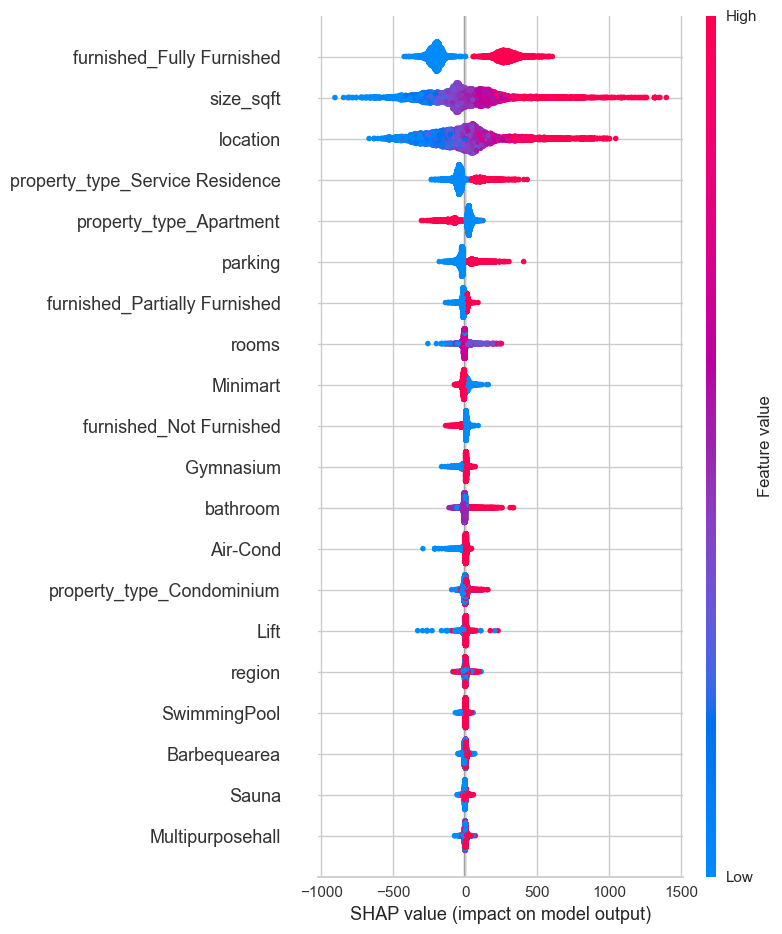

In [47]:
interpret_model(rf_model)

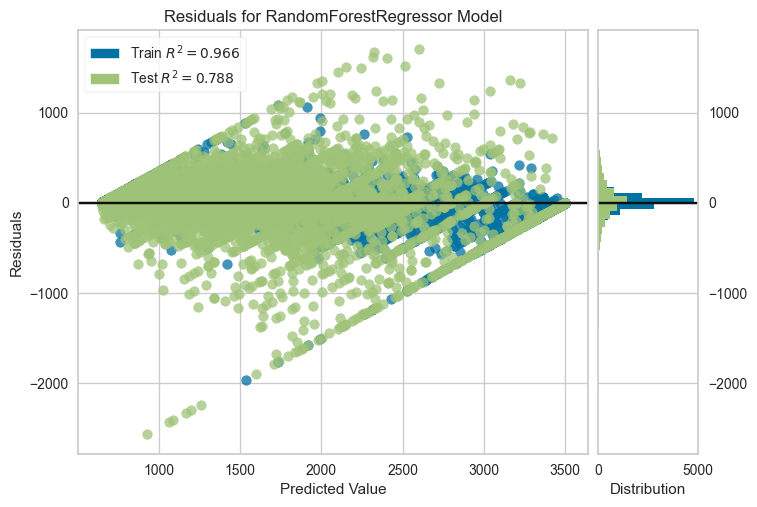

In [48]:
plot_model(rf_model)

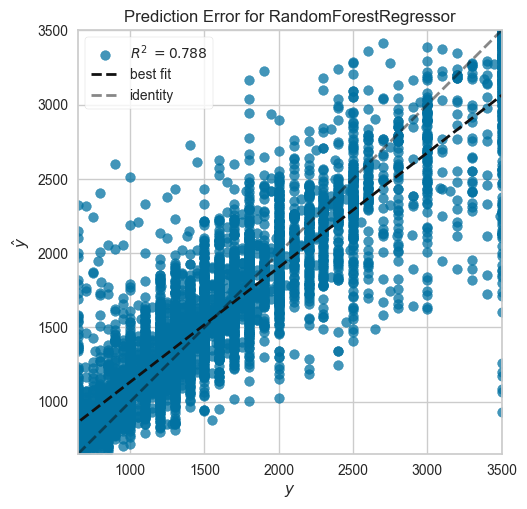

In [49]:
plot_model(rf_model, plot='error')

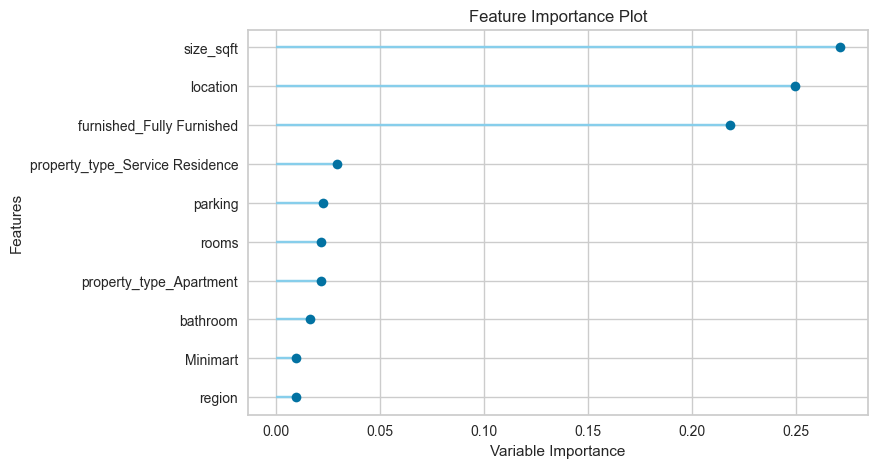

In [50]:
plot_model(rf_model, plot='feature')

In [51]:
evaluate_model(rf_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…